In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils_2 import ImageData, save_image_multiple, save_image
import sys
from PIL import Image

In [2]:
import time

In [3]:
IMG_DIM = 128
LATENT_DIM = 512
DISC_LATENT_DIM = 512
BATCH_SIZE = 64
GAMMA = 0.5
LAMDA = 0.001
OP_BETA = 0.9
OP_LR = 0.0001

In [4]:
def normalize_func(img):
    return (img-127.5)/127.5
def de_normalize_func(img):
    return ((img*127.5)+127.5).astype(np.int)

In [5]:
myImage = ImageData("D:/Jupyter/random dataset/image_dataset_small",10000,batch_size=BATCH_SIZE,resize=(IMG_DIM,IMG_DIM))
total_batches = myImage.total_batches
print("Total number of batches: ",total_batches)

Total number of batches:  157


(-0.5, 127.5, 127.5, -0.5)

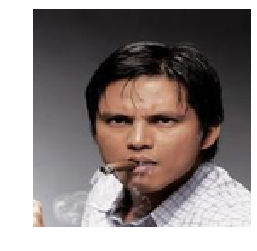

In [6]:
sample = myImage.get_sample_img()
plt.imshow(sample)
plt.axis('off')

In [7]:
tf.reset_default_graph()

In [8]:
x = tf.placeholder(tf.float32,shape=[None,IMG_DIM,IMG_DIM,3],name='input')
z = tf.placeholder(tf.float32,shape=[None,LATENT_DIM],name='latent')
kt = tf.placeholder(tf.float32,shape=[1],name='k_balance')

In [9]:
def generator(z):
    with tf.variable_scope("generator",reuse=tf.AUTO_REUSE):
        x = tf.layers.Dense(4*4*512)(z)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        x = tf.reshape(x,shape=[-1,4,4,512])
        
        """ Block 1 """
        x = tf.layers.Conv2D(256,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(256,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(8,8))
        
        """ Block 2 """
        x = tf.layers.Conv2D(128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(16,16))
        
        x = tf.layers.Conv2D(128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(32,32))
        
        """ Block 3 """
        x = tf.layers.Conv2D(64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(64,64))
        
        """ Block 4 """
        x = tf.layers.Conv2D(32,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(32,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(128,128))
        
        x = tf.layers.Conv2D(3,kernel_size=3,activation='tanh',padding='same')(x)
        return x

def discriminator(imgs):
    with tf.variable_scope("discriminator/encoder", reuse=tf.AUTO_REUSE):
        """ Block 1 """
        enc_in = tf.layers.Conv2D(filters=64,kernel_size=3,padding='same')(imgs)
        x = tf.layers.BatchNormalization()(enc_in)
        x = tf.nn.elu(x)
        
        x = tf.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        x = tf.layers.Conv2D(filters=64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        """ Block 2 """
        x = tf.layers.Conv2D(filters=128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        x = tf.layers.Conv2D(filters=128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        """ Block 3 """
        x = tf.layers.Conv2D(filters=256,kernel_size=3,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        x = tf.layers.Conv2D(filters=256,kernel_size=3,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(x)
        
        """ Block 4 """
        
        x = tf.layers.Conv2D(filters=256,kernel_size=3,strides=(1,1),padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        x = tf.layers.Flatten()(x)
        enc_out = tf.layers.Dense(DISC_LATENT_DIM,activation='linear')(x)
    
    with tf.variable_scope("discriminator/decoder",reuse=tf.AUTO_REUSE):
        dec_in = tf.layers.Dense(4*4*512)(enc_out)
        x = tf.layers.BatchNormalization()(dec_in)
        x = tf.nn.elu(x)
        x = tf.reshape(x,shape=[-1,4,4,512])
        
        """ Block 1 """
        x = tf.layers.Conv2D(256,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(256,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(8,8))
        
        """ Block 2 """
        x = tf.layers.Conv2D(128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(16,16))
        
        x = tf.layers.Conv2D(128,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(32,32))
        
        """ Block 3 """
        x = tf.layers.Conv2D(64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(64,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(64,64))
        
        """ Block 4 """
        x = tf.layers.Conv2D(32,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.layers.Conv2D(32,kernel_size=3,padding='same')(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.elu(x)
        
        x = tf.image.resize_nearest_neighbor(x,size=(128,128))
        
        dec_out = tf.layers.Conv2D(3,kernel_size=3,activation='tanh',padding='same')(x)
        return dec_out

In [10]:
fake_img = generator(z)
real_decode = discriminator(x)
fake_decode = discriminator(fake_img)

decode_real_loss = tf.losses.absolute_difference(x,real_decode)
decode_fake_loss = tf.losses.absolute_difference(fake_img,fake_decode)

disc_loss = decode_real_loss - kt*decode_fake_loss
gen_loss = decode_fake_loss
kt_1 = kt + LAMDA * (GAMMA * decode_real_loss - decode_fake_loss)

convergence_measure = decode_real_loss + tf.abs(GAMMA * decode_real_loss - decode_fake_loss)

tf.add_to_collection('losses',convergence_measure)
generate_img_wrapper = tf.identity(fake_img,name="Generator")

In [11]:
gen_variable = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
dis_variable = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
gen_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in gen_variable])
dis_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in dis_variable])
print("gen_var_count:",gen_var_count)
print("dis_var_count:",dis_var_count)
print("total:",gen_var_count+dis_var_count)

gen_var_count: 6572707
dis_var_count: 8835299
total: 15408006


In [12]:
gen_op = tf.train.AdamOptimizer(OP_LR,beta1=OP_BETA)
gen_train = gen_op.minimize(gen_loss,var_list=gen_variable)

disc_op = tf.train.AdamOptimizer(OP_LR,beta1=OP_BETA)
disc_train = disc_op.minimize(disc_loss,var_list=dis_variable)

In [13]:
test_noise = np.random.standard_normal(size=[36,LATENT_DIM])
test_sample = np.expand_dims(myImage.get_sample_img(normalize_func=normalize_func),0)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
hist = []
#Initial k value
kt_temp = np.zeros(1)

In [16]:
whole_model_saver = tf.train.Saver(tf.global_variables())

# Total_gen_variable contain all the variable nessary to run inference
# which include Batch_norm variables that wasn't present in gen_varible (only trainable variable)
total_gen_variable = [v for v in tf.global_variables() if v.name.startswith('generator') and 'Adam' not in v.name]
generate_model_saver = tf.train.Saver(total_gen_variable)

In [ ]:
start_time = time.time()
for i in range(1,501):
    start_epoch = time.time()
    for j in range (total_batches):
        batch = myImage.get_image(normalize_func=normalize_func)
        noises = np.random.standard_normal(size=[BATCH_SIZE,LATENT_DIM])
        converge_val,kt_temp,_,__ = sess.run([convergence_measure,kt_1,gen_train,disc_train],
                                           feed_dict={x:batch,z:noises,kt:kt_temp})
        sys.stdout.write('\r Epoch {} ({}/{}): Loss = {}, kt = {}'.format(i,j,total_batches,converge_val,kt_temp))
        sys.stdout.flush()
        if (j % (total_batches//3) == 0):
            hist.append(converge_val)
    end_epoch = time.time()
    time_per_epoch = round(end_epoch-start_epoch)
    print('\r Epoch {}: Loss = {}                       {} secs'.format(i,converge_val,time_per_epoch))
    
    gen_imgs = sess.run(fake_img,feed_dict={z:test_noise})
    save_image_multiple('./export/BEGAN/generator_progress/',i,gen_imgs,de_normalize_func=de_normalize_func)
    
    dis_imgs = sess.run(real_decode,feed_dict={x:test_sample})
    save_image('./export/BEGAN/discriminator_progress/',i,dis_imgs[0],de_normalize_func=de_normalize_func)
    
    if (i % 5 == 0):
        whole_model_saver.save(sess,'./Model/BEGAN-Face/BEGAN_{}.ckpt'.format(i))
        generate_model_saver.save(sess,'./Model/BEGAN-Face/inference_model/BEGAN_generate_{}.ckpt'.format(i))
end_time = time.time()
print("Total training time: {} secs".format(round(end_time-start_time)))

 Epoch 1: Loss = 0.2659008502960205                       130 secs
 Epoch 2: Loss = 0.2457224726676941                       123 secs
 Epoch 3: Loss = 0.2111929953098297                       124 secs
 Epoch 4: Loss = 0.20719975233078003                       124 secs
 Epoch 5: Loss = 0.19271749258041382                       125 secs
 Epoch 6: Loss = 0.20817825198173523                       126 secs
 Epoch 7: Loss = 0.20328201353549957                       127 secs
 Epoch 8: Loss = 0.1808958649635315                       126 secs
 Epoch 9: Loss = 0.18736612796783447                       125 secs
 Epoch 10: Loss = 0.15153741836547852                       126 secs
 Epoch 11: Loss = 0.15254583954811096                       127 secs
 Epoch 12: Loss = 0.16116583347320557                       127 secs
 Epoch 13: Loss = 0.16355913877487183                       126 secs
 Epoch 14: Loss = 0.14224988222122192                       128 secs
 Epoch 15: Loss = 0.14747697114944458          

 Epoch 119: Loss = 0.08868701756000519                       124 secs
 Epoch 120: Loss = 0.08584509789943695                       125 secs
 Epoch 121: Loss = 0.08614414930343628                       128 secs
 Epoch 122: Loss = 0.08543218672275543                       129 secs
 Epoch 123: Loss = 0.09949463605880737                       127 secs
 Epoch 124: Loss = 0.09211723506450653                       127 secs
 Epoch 125: Loss = 0.09124606847763062                       129 secs
 Epoch 126: Loss = 0.08920524269342422                       127 secs
 Epoch 127 (13/157): Loss = 0.10185346007347107, kt = [0.01193936]